# Uncertainty Engine SDK example workflows - train & predict

This notebook goes through how you would set up a workflow to train and save a machine-learning model in the Uncertainty Engine. If you haven't yet viewed [`node.ipynb`](./node.ipynb) or [`workflow.ipynb`](./workflow.ipynb) then take a look at them first as they take you through the basics of using nodes and  creating workflows in the Uncertainty Engine.

Start by importing and initializing the `Client` (for more details about the client see the `node.ipynb` example). 

In [ ]:
from uncertainty_engine import Client

client = Client()
client.authenticate()

## Part 1: Building and running a **train** workflow

### Viewing the nodes

Once you have initialised the Uncertainty Engine client you can use the `list_nodes` method to find your node information. Fields such as the `description`, `inputs` and `outputs` are particularly useful for building your workflow.

In [30]:
from pprint import pprint

# Create a dictionary with node IDs as keys
nodes = client.list_nodes()
nodes_by_id = {node["id"]: node for node in nodes}

# Print the details of the `TrainModel` node
pprint(nodes_by_id["TrainModel"])

{'cache_url': 'redis-13325.c338.eu-west-2-1.ec2.redns.redis-cloud.com',
 'category': 'MachineLearningModels',
 'cost': 5,
 'description': 'Train a machine-learning model',
 'id': 'TrainModel',
 'image_name': 'uncertainty-engine-train-model-node',
 'inputs': {'config': {'default': None,
                       'description': 'Configuration for the model',
                       'label': 'Model Config',
                       'required': True,
                       'set_in_node': False,
                       'type': 'ModelConfig'},
            'inputs': {'default': None,
                       'description': 'Input dataset for training the model',
                       'label': 'Input Dataset',
                       'required': True,
                       'set_in_node': False,
                       'type': 'CSVDataset'},
            'outputs': {'default': None,
                        'description': 'Output dataset for training the model',
                        'label': 'Output Da

Now we know that the `TrainModel` node needs the following inputs:
- **Input Dataset:** Train input data
- **Output Dataset:** Target output data
- **Model Config:** A model config node specifying the parameters we wish to use for training

### Creating our train and test data

In this example we will use some synthetic data to demonstrate how it can be used to train a model. 

We're using the Forrester function as our "ground truth" target function and then 10 sampled points along it as our training data.

In [31]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility and assign number of rows
np.random.seed(42)
n_rows = 10

# Target function: forrester function
def f(x, a=6, b=12):
    return -((a * x - 2) ** 2) * np.sin(b * x - 4)

# Generate synthetic data to train on
X_train = np.random.uniform(0, 1, size=n_rows) # 10 randomly sampled points
y_train = f(X_train) # Place those points into the target function
train_df = pd.DataFrame({
    'x': X_train,
    'y': y_train
})

# Generate "truth" data for testing
X_test = np.linspace(0, 1, 100)
y_test = f(X_test)
test_df = pd.DataFrame({"x": X_test, "y": y_test})

### Saving and uploading training and test data

To use the synthetic data generated above within workflows created in the Uncertainty Engine we need to upload it.

To do this we'll first save the data as a set of CSV files.

In [ ]:
# Convert dataframes to CSV strings
x_csv = train_df[["x"]].to_csv(index=False)
y_csv = train_df[["y"]].to_csv(index=False)
x_test_csv = test_df[["x"]].to_csv(index=False)

# Save CSV strings to files
for filename, data in zip(
    ["x_train.csv", "y_train.csv", "x_test.csv"], [x_csv, y_csv, x_test_csv]
):
    with open(filename, "w") as f:
        f.write(data)

We'll next specify the Uncertainty Engine project that the data will be uploaded into. This notebook will work under the assumption that a user still has the "Personal" project that all new Uncertainty Engine accounts are created with.

In [5]:
# List all available projects
projects = client.projects.list_projects()

# Find the project named "Personal"
personal_project = next(p for p in projects if p.name == "Personal")

We'll now upload the datasets we have created into the "Personal" project.

In [6]:
# Define an empty dictionary to hold resource IDs
resource_ids: dict[str,str] = dict()

# Upload datasets and store their resource IDs
for resource_name, file_path in zip(
    ["my-x-dataset", "my-y-dataset", "my-x-test-dataset"],
    ["x_train.csv", "y_train.csv", "x_test.csv"],
):
    resource_id = client.resources.upload(
        project_id=personal_project.id,
        name=resource_name,
        file_path=file_path,
        resource_type="dataset",
    )
    resource_ids[resource_name] = resource_id
    print(f"Uploaded {file_path} as resource '{resource_name}'")

Uploaded x_train.csv as resource 'my-x-dataset'
Uploaded y_train.csv as resource 'my-y-dataset'
Uploaded x_test.csv as resource 'my-x-test-dataset'


### Configuring our model

Above we saw that one of the required inputs of the `TrainModel` node is a `ModelConfig`. To define this `ModelConfig` we need a `ModelConfig` node. Like for the `TrainModel` node we can examine the inputs and outputs of the `ModelConfig` node.

In [8]:
pprint(nodes_by_id["ModelConfig"])

{'cache_url': 'redis-13325.c338.eu-west-2-1.ec2.redns.redis-cloud.com',
 'category': 'MachineLearningModels',
 'cost': 1,
 'description': 'Config for a machine learning model',
 'id': 'ModelConfig',
 'image_name': 'uncertainty-engine-model-config-node',
 'inputs': {'input_retained_dimensions': {'default': None,
                                          'description': 'Number of dimensions '
                                                         'to retain in the '
                                                         'input data',
                                          'label': 'Input Retained Dimensions',
                                          'required': False,
                                          'set_in_node': True,
                                          'type': 'int'},
            'input_variance': {'default': None,
                               'description': 'Percentage of variance to '
                                              'retain in the input data',

The `ModelConfig` node accepts several optional parameters that control model training. However, as none of the inputs are required we can just use the default input parameters for now. This will configure our model as a `SingleTaskGP` which is ideal for our regression task.

### Constructing a workflow

First, import and initialise the `Graph` class.


In [36]:
from uncertainty_engine.graph import Graph

# Create a new graph
train_graph = Graph()

In [37]:
from uncertainty_engine.nodes.base import Node

# Define the model config node
model_config = Node(
    node_name="ModelConfig",
    label="Model Config",
)

# Add node to the graph and connect it to the train node
train_graph.add_node(model_config)

# Add a handle to the the config output
output_config = model_config.make_handle("config")

Next, we add nodes to load the training datasets and connect them to the `TrainModel` node, which performs the model training.

In [ ]:
from uncertainty_engine.nodes.resource_management import LoadDataset

# Create a LoadDataset node for the x training data
x = LoadDataset(
  label="LoadDatasetX", # the node's label (needs to be unique in the graph)
  project_id = personal_project.id, # the project id
  file_id = resource_ids["my-x-dataset"], # the resource id of the file you want to load
)
# Create a LoadDataset node for the y training data
y = LoadDataset(
  label="LoadDatasetY", # the node's label (needs to be unique in the graph)
  project_id = personal_project.id, # the project id
  file_id = resource_ids["my-y-dataset"], # the resource id of the file you want to load
)

train_graph.add_node(x)
train_graph.add_node(y)

In [39]:
# Create handles for the loaded dataset files
x_handle = x.make_handle("file")
y_handle = y.make_handle("file")

# Create the TrainModel node
train_model = Node(
    node_name="TrainModel",
    label="Train Model",
    config=output_config,
    inputs=x_handle,
    outputs=y_handle,
)

# Add the node to the graph
train_graph.add_node(train_model)

### Assigning an output node

Now our graph has been built we can use an output node to decide how we wish to collect the output. The output nodes we could use here are:
- **Download:** To download the model JSON using an AWS pre-signed url.
- **Save:** To save the model JSON to the Uncertainty Engine cloud.

First lets make a handle for the output `model` of the `Train` node.

In [40]:
output_model = train_model.make_handle("model")

In this case we will use the `Download` node to get a pre-signed URL for our trained model so we can use it for the `Predict` part of this notebook.

In [41]:
# Define the Download node
download = Node(
  node_name="Download",
  label="Download",
  file=output_model
)

# Add the download node to the graph and connect it to the train node
train_graph.add_node(download)

# Print graph to check the structure
pprint(train_graph.nodes)

{'nodes': {'Download': {'inputs': {'file': {'node_handle': 'model',
                                            'node_name': 'Train Model'}},
                        'type': 'Download'},
           'LoadDatasetX': {'inputs': {'file_id': {'node_handle': 'LoadDatasetX_file_id',
                                                   'node_name': '_'},
                                       'project_id': {'node_handle': 'LoadDatasetX_project_id',
                                                      'node_name': '_'}},
                            'type': 'LoadDataset'},
           'LoadDatasetY': {'inputs': {'file_id': {'node_handle': 'LoadDatasetY_file_id',
                                                   'node_name': '_'},
                                       'project_id': {'node_handle': 'LoadDatasetY_project_id',
                                                      'node_name': '_'}},
                            'type': 'LoadDataset'},
           'Model Config': {'inputs': {}, 'type':

### Executing a workflow

Create the executable workflow by wrapping our graph in the `Workflow` node and defining the `requested_output` as the output handle of the `Download` node.

In [42]:
from uncertainty_engine.nodes.workflow import Workflow

# Define our output handles
output_download_model = download.make_handle("file")

# Wrap the graph in a workflow node
train_workflow = Workflow(
    graph=train_graph.nodes,
    inputs=train_graph.external_input,
    external_input_id=train_graph.external_input_id,
    requested_output={
        "Trained Model": output_download_model.model_dump(),
        }
    )

Now, we can execute the workflow by running `client.run_node(workflow)` and passing the workflow object. This may take a minute for training.

In [43]:
train_response = client.run_node(train_workflow)

In [44]:
pprint(train_response.model_dump())

{'inputs': {'external_input_id': '_',
            'graph': {'nodes': {'Download': {'inputs': {'file': {'node_handle': 'model',
                                                                 'node_name': 'Train '
                                                                              'Model'}},
                                             'type': 'Download'},
                                'LoadDatasetX': {'inputs': {'file_id': {'node_handle': 'LoadDatasetX_file_id',
                                                                        'node_name': '_'},
                                                            'project_id': {'node_handle': 'LoadDatasetX_project_id',
                                                                           'node_name': '_'}},
                                                 'type': 'LoadDataset'},
                                'LoadDatasetY': {'inputs': {'file_id': {'node_handle': 'LoadDatasetY_file_id',
                                 

Following the presigned URL will download the trained model. In the following cell we use this link to define our `model_json` so that it can be used for our `predict` workflow.

In [45]:
import requests

# Get the presigned URL from the response
trained_model_url = train_response.outputs["outputs"]["Trained Model"]

def get_presigned_url(url):
    """
    Get the contents from the presigned url.
    """
    url = url.replace("https://", "http://")
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    return response

# Get the model from the presigned URL
model_response = get_presigned_url(trained_model_url)
model_json = model_response.json()

## Part 2: Building and running a **predict** workflow

Next, we will use the saved model json to make predictions on a sample dataset. If we take a look at the `PredictModel` node information we can see that the following inputs are needed to run the node:
- **Dataset:** The input data on which to make the output predictions (this will be our `test_df` dataset)
- **Model:** The pre-trained model to be used to make the predictions
- **Seed (optional):** A random seed for reproducibility

In [46]:
# Print `PredictModel` node details
pprint(nodes_by_id["PredictModel"])

{'cache_url': 'redis-13325.c338.eu-west-2-1.ec2.redns.redis-cloud.com',
 'category': 'MachineLearningModels',
 'cost': 5,
 'description': 'Make predictions using a machine-learning model',
 'id': 'PredictModel',
 'image_name': 'uncertainty-engine-predict-model-node',
 'inputs': {'dataset': {'default': None,
                        'description': 'Dataset for predictions',
                        'label': 'Dataset',
                        'required': True,
                        'set_in_node': False,
                        'type': 'CSVDataset'},
            'model': {'default': None,
                      'description': 'Machine-learning model',
                      'label': 'Model',
                      'required': True,
                      'set_in_node': False,
                      'type': 'MachineLearningModel'}},
 'label': 'Predict Model',
 'load_balancer_url': 'http://dev-un-uncer-DSI4Brpilk4c-982463797.eu-west-2.elb.amazonaws.com',
 'long_description': 'Generate prediction

Now we know what input parameters the `PredictModel` node needs we can start constructing our workflow.

### Constructing the prediction workflow

We will now build the prediction workflow by:
1. Initialising the prediction graph.
2. Loading the test data using a `LoadDataset` node.
3. Creating a handle for the loaded test data.
4. Creating the `PredictModel` node using the loaded test data and trained model.
5. Adding output nodes for predictions and uncertainty.

In [47]:
# Step 1: Initialise the prediction graph
predict_graph = Graph()

In [48]:
# Step 2: Load test data using a LoadDataset node
x_test_node = LoadDataset(
    label="LoadDatasetXTest",
    project_id=PROJECT_ID,
    file_id=x_test_resource_id,
)
predict_graph.add_node(x_test_node)

In [49]:
# Step 3: Create handle for loaded test data file
x_test_handle = x_test_node.make_handle("file")

In [50]:
# Step 4: Create the PredictModel node using the loaded test data handle
predict = Node(
    node_name="PredictModel",
    label="Predict",
    dataset=x_test_handle.model_dump(),  # Use the handle, not raw CSV
    model=model_json,
    seed=42,
)
predict_graph.add_node(predict)

We can use the `Download` node to get our resulting datasets. We will need one `Download` node for both the predictions and uncertainty output.

In [51]:
# Step 5: Add output nodes for predictions and uncertainty

# Add handles to the prediction and uncertainty outputs
output_predictions = predict.make_handle("prediction")
output_uncertainty = predict.make_handle("uncertainty")

# Define download nodes for predictions and uncertainty
download_predictions = Node(
    node_name="Download",
    label="Download Predictions",
    file=output_predictions
)
download_uncertainty = Node(
    node_name="Download",
    label="Download Uncertainty",
    file=output_uncertainty
)

# Add download nodes to the graph and connect them to the predict node
predict_graph.add_node(download_predictions)
predict_graph.add_node(download_uncertainty)

# Print the predict graph
pprint(predict_graph.nodes)

{'nodes': {'Download Predictions': {'inputs': {'file': {'node_handle': 'prediction',
                                                        'node_name': 'Predict'}},
                                    'type': 'Download'},
           'Download Uncertainty': {'inputs': {'file': {'node_handle': 'uncertainty',
                                                        'node_name': 'Predict'}},
                                    'type': 'Download'},
           'LoadDatasetXTest': {'inputs': {'file_id': {'node_handle': 'LoadDatasetXTest_file_id',
                                                       'node_name': '_'},
                                           'project_id': {'node_handle': 'LoadDatasetXTest_project_id',
                                                          'node_name': '_'}},
                                'type': 'LoadDataset'},
           'Predict': {'inputs': {'dataset': {'node_handle': 'Predict_dataset',
                                              'node_name': '_

### Executing the workflow

Now we can run our workflow using the `Workflow` node.

In [52]:
# Define the output handles for the download nodes
output_download_predictions = download_predictions.make_handle("file")
output_download_uncertainty = download_uncertainty.make_handle("file")

# Wrap the predict graph in a workflow node
predict_workflow = Workflow(
    graph=predict_graph.nodes,
    inputs=predict_graph.external_input,
    external_input_id=predict_graph.external_input_id,
    requested_output={
        "Predictions": output_download_predictions.model_dump(),
        "Uncertainty": output_download_uncertainty.model_dump(),
        }
    )

# Run the predict workflow and get the response
predict_response = client.run_node(predict_workflow)

We can download the results and save the `predictions` and `uncertainty` as pandas dataframes so that we can plot them.

In [53]:
from io import StringIO

# Download the predictions and save as a DataFrame
predictions_response = get_presigned_url(predict_response.outputs["outputs"]["Predictions"])
predictions_df = pd.read_csv(StringIO(predictions_response.text))  # Save the predictions to a DataFrame

# Download the uncertainty and save as a DataFrame
uncertainty_response = get_presigned_url(predict_response.outputs["outputs"]["Uncertainty"])
uncertainty_df = pd.read_csv(StringIO(uncertainty_response.text))  # Save the uncertainty to a DataFrame

### Plot the results

Finally, we can plot our predictions vs our truth function. 

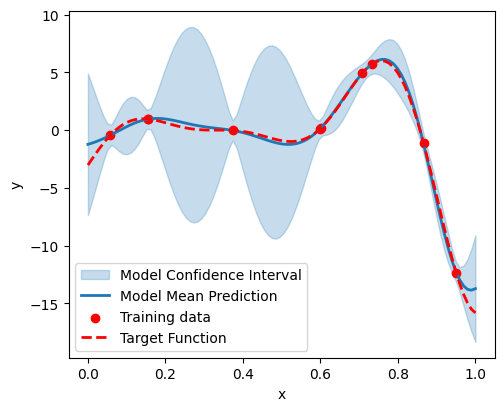

In [54]:
import matplotlib.pyplot as plt

CONFIDENCE_99_ZSCORE = 2.58  # z-score for 99% confidence interval

y_pred = predictions_df.to_numpy().flatten()
y_std = uncertainty_df.to_numpy().flatten()

plt.figure(figsize=(5.5, 4.5))

plt.fill_between(
    X_test,
    (y_pred - CONFIDENCE_99_ZSCORE * y_std),
    (y_pred + CONFIDENCE_99_ZSCORE * y_std),
    color="C0",
    alpha=0.25,
    label="Model Confidence Interval",
)
plt.plot(X_test, y_pred, c="C0", linewidth=2, label="Model Mean Prediction")

plt.scatter(
    X_train,
    y_train,
    color="red",
    label="Training data",
)
plt.xlabel("x")
plt.ylabel("y")

plt.plot(X_test, y_test, c="r", linewidth=2, linestyle="dashed", label="Target Function")
plt.legend()
plt.show()

### Conclusion

Qualitatively we can see that the model predictions closely follow the ground truth. The plot also shows the uncertainty on the model predictions. As is typical for a Gaussian Process model, the uncertainty is generally larger in areas with sparse training samples.

In this notebook we have demonstrated how to use the SDK to train a model and then use it to make predictions. 

If you wanted to lead on from this and get a more accurate reading of how well the model performed you could try using the `ScoreModel` node to evaluate the model. Otherwise, checkout [`resource.ipynb`](./resource.ipynb) to learn about how you can use resources in the Uncertainty Engine SDK.